#### Hate Speech Detection
##### Punto 1:
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione
del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema
Profiling-UD.

#### Pre-Processing
Per prima cosa devo pulire i dataset (Training e Test) che contengono tanti simboli, emoticon ed altri elementi inutili alla mia analisi linguistica.
Per fare questo utilizzo il seguente programma che si occupa di
<ul>
    <li>Eliminare tutte le stringhe '@...', il dataset è pieno di '@user'</li>
    <li>Eliminare le stringhe 'URL' che si presentano tante volte nella stessa frase</li>
    <li>Eliminare caratteri speciali come #,+,|,&... che non aggiungono significato all'analisi</li>
    <li>Eliminare emoticon</li>    
    <li>Ridurre gli spazi multipli a uno soltanto</li>
    <li>Rimuovere gli spazi all'interno e alla fine della stringa</li>
    <li>Trasformare il testo in minuscolo</li>
</ul>

In [22]:
import re
import pandas as pd

def cleaning_data(text):
    
    text = re.sub(r'@\w+', '', text)  # Rimuovi menzioni (@user)
    text = re.sub(r'URL', '', text)  # Rimuovi "URL"
    text = re.sub(r'#', '', text)  # Rimuovi hashtag (#)
    
    # Mantieni caratteri accentati eliminando solo simboli non desiderati
    text = re.sub(r'[^\x20-\x7EàèìòùáéíóúÀÈÌÒÙ]', '', text)  # Elimina simboli non ASCII, ma mantieni accenti

    # Riduci ripetizioni
    text = re.sub(r'\.{2,}', '...', text)  # Riduci serie di puntini di sospensione a "..."
    text = re.sub(r'-{2,}', '-', text)  # Riduci serie di trattini a uno singolo
    text = re.sub(r'\?{2,}', '?', text)  # Riduci serie di punti interrogativi a uno singolo
    text = re.sub(r'!{2,}', '!', text)  # Riduci serie di punti esclamativi a uno singolo
    text = re.sub(r',{2,}', ',', text)  # Riduci serie di virgole a una singola virgola

    emoticons = [r":\)", r":\(", r":P", r":3", r":-\)", r":-\(", r":'\)", r":'\(", r":D"]
    for emoticon in emoticons:
        text = re.sub(emoticon, '', text)
            
    # Rimuovi simboli non necessari
    text = re.sub(r'[+*|\\&=]', '', text)
    
    
    text = re.sub(r'^[^\wèùìàéòíó]', '', text) #Elimina la punteggiatura ad inizio frase
    text = re.sub(r'\s+', ' ', text) #Elimina spazi multipli
    text = text.strip()  # Rimuovi spazi iniziali e finali
    text = text.lower()  # Converti tutto in minuscolo
    
    return text

def clean_dataset(file_path, output_file):
    # Specifica il parser 'python' e il separatore corretto
    dataframe = pd.read_csv(file_path, sep=';') 
    
    # Applica cleaning_data direttamente sulla colonna B e la aggiorna coi dati puliti
    dataframe.iloc[:, 1] = dataframe.iloc[:, 1].apply(cleaning_data) 

    # Elimina righe con frasi troppo corte
    dataframe = dataframe[dataframe.iloc[:, 1].str.len() >= 5] 
    
    # Genera file di output
    dataframe.to_csv(output_file, index=False, sep=';')
    print(f"Dataset pulito con successo...")

# File INPUT 
training_file = '1_Train_Test_CSV/TrainingSet.csv' 
test_file1 = '1_Train_Test_CSV/Test_News.csv'  
test_file2 = '1_Train_Test_CSV/Test_Tweets.csv'  
gold_n = '1_Train_Test_CSV/GOLD_N.csv'
gold_t = '1_Train_Test_CSV/GOLD_T.csv'

# File di OUTPUT
output_training = '2_Train_Test_CLEAN_CSV/TrainingClean.csv'
output_test1 = '2_Train_Test_CLEAN_CSV/TestNewsClean.csv'
output_test2 = '2_Train_Test_CLEAN_CSV/TestTweetsClean.csv'
output_test3 = '2_Train_Test_CLEAN_CSV/GOLD_Nclean.csv'
output_test4 = '2_Train_Test_CLEAN_CSV/GOLD_Tclean.csv'

# Applica le funzioni
clean_dataset(training_file, output_training)  
clean_dataset(test_file1, output_test1)        
clean_dataset(test_file2, output_test2)
clean_dataset(gold_n, output_test3)        
clean_dataset(gold_t, output_test4)


Dataset Pulito :)
Dataset Pulito :)
Dataset Pulito :)
Dataset Pulito :)
Dataset Pulito :)


#### Ecco un esempio di come il dataset era prima e dopo la pulizia.

##### Prima della pulizia: 

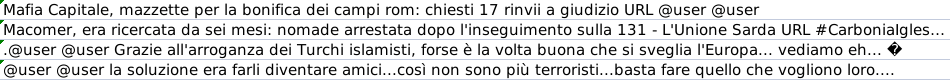

##### Dopo la pulizia: 

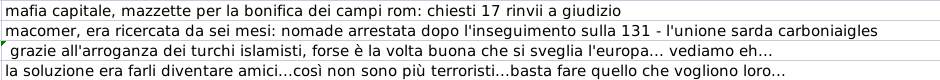

#### Preparazione file per Profiling-UD

Una volta puliti i nostri dati è necessario prendere le singole frasi di ogni dataset e salvare ogni frase su uno specifico file di testo.
Ho scelto di procedere nel seguente modo:

<ul>
    <li><b>Training:</b></li></b>ho 6837 frasi, ognuna sarà salvata su un file.txt che va da 0001.txt a 6837.txt</li>
    <li><b>Test:</b></li>ho 400 frasi relative a News e 1261 relative a commenti Twitter, le combino in un'unica cartella e le separo nel seguente modo: da 0001N.txt a 1262N.txt e da 001T.txt a 499T.txt
</ul>

Tali dati saranno ovviamente divisi in due cartelle differenti e una volta zippate le cartelle saranno passate a Profiling-UD al fine di ottenere il file con le features.
In seguito c'è il programma che ho utilizzato per eseguire questa separazione.

In [1]:
import os #la libreria che mi permette di interagire col file system
import pandas as pd

# FUNZIONE CON CUI CREO I FILE SINGOLI .txt
def create_text_files(input_file):
    try:
        df = pd.read_csv(input_file, sep=';')  
        
        # DETERMINO CARTELLA DI OUTPUT
        # In base al nome del mio dataset decido poi la cartella in cui collocare il file.txt
        # Per quanto riguarda i file del test set li inserisco sempre in una sola cartella ma li differenzio in base al tipo T o N
        
        if 'TrainingClean' in input_file:
            output_folder = 'PUD_training'
            file_prefix = ''  # Qui metto solo un numero tanto non devo fare distinzione
            message = "Tutti i file di Training sono stati creati con successo."
        elif 'GOLD_Tclean' in input_file:
            output_folder = 'PUD_test'
            file_prefix = 'T'  # Prefisso T per i tweet
            message = "Tutti i file di Test (T) sono stati creati con successo."
        elif 'GOLD_Nclean' in input_file:
            output_folder = 'PUD_test'
            file_prefix = 'N'  # Prefisso N per news
            message = "Tutti i file di Test (N) sono stati creati con successo."
        else:
            raise ValueError("Il nome del file di input non è corretto.")
        
        # Creo la cartella di OUTPUT
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            print(f"Cartella '{output_folder}' creata.")
        else:
            print(f"Cartella '{output_folder}' già esistente.")
        
        # TROVA IL NUMERO MASSIMO DI FRASI nel dataset di input!
        # Questo mi serve per dare ad ogni file un valore che va da 0000.txt a nnnn.txt 
        # Mi serve per poi ordinare il dataset
        
        num_files = len(df)
        padding_length = len(str(num_files))  # Tipo se ho 500 frasi nel dataset avrò da 000.txt a nnn.txt file nella cartella

        #CREO IL FILE:
        # Per ogni frase del dataset vado a creare un file .txt
        file_count = 0
        
        #itero le righe del df
        for index, row in df.iterrows():
            #Questo mi permette di incrementare ogni volta l'indice e mantenerlo dentro il padding
            #Avrà così frase 0001.txt, 0002.txt ecc...
            if 'Training' in input_file:
                file_name = f"{str(index + 1).zfill(padding_length)}.txt"  
            else:
                #Qui ho anche il prefisso perchè voglio distinguere Twitter e News 
                file_name = f"{file_prefix}{str(index + 1).zfill(padding_length)}.txt"
            
            # Percorso del file nella cartella appropriata
            file_path = os.path.join(output_folder, file_name)
            
            # Estraggo la frase dalla seconda colonna del dataset 
            sentence = row.iloc[1]
            
            # Scrivo la frase nel file .txt
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(sentence)
            
            # Incrementa il contatore dei file creati
            file_count += 1

        # Stampa il messaggio finale con il numero di file creati
        print(f"{message} Numero totale di file creati: {file_count}")
    
    except FileNotFoundError:
        print(f"Errore: il file {input_file} non è stato trovato.")
    except Exception as e:
        print(f"Errore durante la creazione dei file: {e}")

# Percorsi dei file di input
training_file = '2_Train_Test_CLEAN_CSV/TrainingClean.csv'
testT_file = '2_Train_Test_CLEAN_CSV/GOLD_Tclean.csv'
testN_file = '2_Train_Test_CLEAN_CSV/GOLD_Nclean.csv'

# Chiamata alla funzione per creare i file .txt per ciascun dataset
create_text_files(training_file)  
create_text_files(testT_file)     
create_text_files(testN_file)


Cartella 'PUD_training' creata.
Tutti i file di Training sono stati creati con successo. Numero totale di file creati: 6837
Cartella 'PUD_test' creata.
Tutti i file di Test (T) sono stati creati con successo. Numero totale di file creati: 1262
Cartella 'PUD_test' già esistente.
Tutti i file di Test (N) sono stati creati con successo. Numero totale di file creati: 499


#### Risultati Profiling-UD:

Dopo aver passato le cartelle zippate a Profiling-UD ho ottenuto i file.csv contenenti le features linguistiche sia per quanto riguarda training che test. Prima di procedere con la normalizzazione analizziamo i file ottenuti.


In [3]:
import pandas as pd

def analyze_csv_files(file1, file2):
    try:
       
        df1 = pd.read_csv(file1, sep='\t', encoding='utf-8')
        df2 = pd.read_csv(file2, sep='\t', encoding='utf-8')

        #Utilizzo il metodo .shape per analizzare le dimensioni dei file e le features.
        num_rows_file1 = df1.shape[0]
        num_columns_file1 = df1.shape[1]
        features_file1 = df1.columns.tolist()

        num_rows_file2 = df2.shape[0]
        num_columns_file2 = df2.shape[1]
        features_file2 = df2.columns.tolist()

        # Stampa i risultati - Stampo solo le prime 20 features
        print(f"File 1: {file1}")
        print(f"Numero di righe: {num_rows_file1}")
        print(f"Numero di colonne: {num_columns_file1}")
        print(f"Prime 20 features: {features_file1[:20]}\n")

        print(f"File 2: {file2}")
        print(f"Numero di righe: {num_rows_file2}")
        print(f"Numero di colonne: {num_columns_file2}")
        print(f"Prime 20 features: {features_file2[:20]}\n")

        # Guardo le features che sono presenti in uno piuttosto che nell'altro file e poi le stampo
        only_in_file1 = set(features_file1) - set(features_file2)
        only_in_file2 = set(features_file2) - set(features_file1)

        if only_in_file1:
            print(f"Features presenti solo in {file1}:")
            for feature in only_in_file1:
                print(feature)
        else:
            print(f"Nessuna feature unica in {file1}")

        if only_in_file2:
            print(f"Features presenti solo in {file2}:")
            for feature in only_in_file2:
                print(feature)
        else:
            print(f"Nessuna feature unica in {file2}")

    except FileNotFoundError as e:
        print(f"Errore: {e}")
    except pd.errors.EmptyDataError:
        print(f"Errore: il file {file1} o {file2} è vuoto.")
    except Exception as e:
        print(f"Errore durante l'analisi dei file: {e}")

# Percorsi dei file CSV da analizzare
file1_path = 'TrainingFeatures.csv'  
file2_path = 'TestFeatures.csv'    

analyze_csv_files(file1_path, file2_path)


File 1: TrainingFeatures.csv
Numero di righe: 6837
Numero di colonne: 136
Prime 20 features: ['Filename', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'upos_dist_ADJ', 'upos_dist_ADP', 'upos_dist_ADV', 'upos_dist_AUX', 'upos_dist_CCONJ', 'upos_dist_DET', 'upos_dist_INTJ', 'upos_dist_NOUN', 'upos_dist_NUM', 'upos_dist_PRON', 'upos_dist_PROPN', 'upos_dist_PUNCT', 'upos_dist_SCONJ', 'upos_dist_SYM', 'upos_dist_VERB']

File 2: TestFeatures.csv
Numero di righe: 1761
Numero di colonne: 135
Prime 20 features: ['Filename', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'upos_dist_ADJ', 'upos_dist_ADP', 'upos_dist_ADV', 'upos_dist_AUX', 'upos_dist_CCONJ', 'upos_dist_DET', 'upos_dist_INTJ', 'upos_dist_NOUN', 'upos_dist_NUM', 'upos_dist_PART', 'upos_dist_PRON', 'upos_dist_PROPN', 'upos_dist_PUNCT', 'upos_dist_SCONJ', 'upos_dist_SYM']

Features presenti solo in TrainingFeatures.csv:
prep_dist_5
verbs_num_pers_dist_Plur+
Features presenti solo in TestFeatures.csv:
up

Procedo nel eliminare le colonne che non sono in comune onde <b>evitare problemi di lettura dei file</b> nelle fasi successive dell'analisi.

In [2]:
import pandas as pd

def filter_common_columns(file1, file2, output_file1, output_file2):
    try:
        
        df1 = pd.read_csv(file1, sep='\t', encoding='utf-8')
        df2 = pd.read_csv(file2, sep='\t', encoding='utf-8')

        # Prendo l'INTERSEZIONE
        common_columns = list(set(df1.columns).intersection(set(df2.columns)))
        df1_common = df1[common_columns]
        df2_common = df2[common_columns]

        df1_common.to_csv(output_file1, sep='\t', index=False, encoding='utf-8')
        df2_common.to_csv(output_file2, sep='\t', index=False, encoding='utf-8')

        #I dati che ottengo: - Alla fine perdo 3 colonne di feature 
        print(f"Numero di colonne comuni: {len(common_columns)}")
        print(f"File 1 filtrato salvato in: {output_file1}")
        print(f"File 2 filtrato salvato in: {output_file2}")

    except FileNotFoundError as e:
        print(f"Errore: {e}")
    except pd.errors.EmptyDataError:
        print(f"Errore: il file {file1} o {file2} è vuoto.")
    except Exception as e:
        print(f"Errore durante l'analisi dei file: {e}")

file1_path = 'TrainingFeatures.csv' 
file2_path = 'TestFeatures.csv'    

#Nome del output filtrato
output_file1_path = 'TrainingFeatures_filtered.csv'
output_file2_path = 'TestFeatures_filtered.csv'

filter_common_columns(file1_path, file2_path, output_file1_path, output_file2_path)



Numero di colonne comuni: 134
File 1 filtrato salvato in: TrainingFeatures_filtered.csv
File 2 filtrato salvato in: TestFeatures_filtered.csv


#### Normalizzazione delle Features
A questo punto Training e Test hanno le stesse features, prima di addestrare il classificatore è necessario procedere con la normalizzazione delle features di training e test.
Per fare questo, come visto a lezione, utilizzerò il <b>MinMax Scaler</b>:

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carica i dataset
df_train = pd.read_csv('TrainingFeatures_filtered.csv', sep='\t')
df_test = pd.read_csv('TestFeatures_filtered.csv', sep=',')

print(df_train.columns)
print(df_test.columns)

# Separa le colonne di etichetta (ad es. 'Hate Speech') dal resto dei dati
# Supponiamo che la colonna di etichetta si chiami 'hate_speech_label'
label_column = 'hs'
df_train_labels = df_train[label_column]
df_test_labels = df_test[label_column]

# Rimuovi le colonne di etichetta dai dati di input che vogliamo normalizzare
df_train_numeric = df_train.drop(columns=[label_column]).select_dtypes(include=['float64', 'int64'])
df_test_numeric = df_test.drop(columns=[label_column]).select_dtypes(include=['float64', 'int64'])

# Inizializza il MinMaxScaler
scaler = MinMaxScaler()

# Fit del scaler sui dati di training
scaler.fit(df_train_numeric)

# Trasforma sia i dati di training che di test utilizzando i parametri calcolati
train_scaled = scaler.transform(df_train_numeric)
test_scaled = scaler.transform(df_test_numeric)

# Crea DataFrame per i dati normalizzati
df_train_scaled = pd.DataFrame(train_scaled, columns=df_train_numeric.columns)
df_test_scaled = pd.DataFrame(test_scaled, columns=df_test_numeric.columns)

# Riaggiungi la colonna di etichetta alle versioni normalizzate
df_train_scaled[label_column] = df_train_labels.values
df_test_scaled[label_column] = df_test_labels.values
Schermata del 2024-10-11 15-17-41
# Salva i file normalizzati con la tabulazione come separatore
df_train_scaled.to_csv('training_file_normalized.csv', index=False, sep='\t')
df_test_scaled.to_csv('test_file_normalized.csv', index=False, sep='\t')

print("I file normalizzati sono stati salvati con successo.")




Index(['aux_mood_dist_Cnd', 'verbs_num_pers_dist_Sing+3', 'dep_dist_ccomp',
       'upos_dist_CCONJ', 'dep_dist_aux', 'dep_dist_parataxis',
       'avg_max_depth', 'upos_dist_SYM', 'upos_dist_ADV',
       'verbs_form_dist_Ger',
       ...
       'obj_pre', 'avg_max_links_len', 'upos_dist_DET', 'avg_token_per_clause',
       'subordinate_dist_4', 'aux_num_pers_dist_Plur+3', 'verb_edges_dist_6',
       'dep_dist_obl:agent', 'aux_num_pers_dist_Plur+2', 'hs'],
      dtype='object', length=135)
Index(['aux_mood_dist_Cnd', 'verbs_num_pers_dist_Sing+3', 'dep_dist_ccomp',
       'upos_dist_CCONJ', 'dep_dist_aux', 'dep_dist_parataxis',
       'avg_max_depth', 'upos_dist_SYM', 'upos_dist_ADV',
       'verbs_form_dist_Ger',
       ...
       'obj_pre', 'avg_max_links_len', 'upos_dist_DET', 'avg_token_per_clause',
       'subordinate_dist_4', 'aux_num_pers_dist_Plur+3', 'verb_edges_dist_6',
       'dep_dist_obl:agent', 'aux_num_pers_dist_Plur+2', 'hs'],
      dtype='object', length=135)
I file nor

#### Resoconto:

<ul>
    <li>Per prima cosa sono stati <b>puliti</b> i dataset di training e test</li>
    <li>Ho estratto le frasi singole, inserite in una cartella zip e le ho passate a <b>Profiling-UD</b>. Sia per Training che per Test</li>
    <li>Ho quindi preso i file csv risultanti da profiling UD e li ho "filtrati" mantenendo soltanto le colonne che hanno in comune.
    In questo modo ho ottenuto due file aventi ciascuno <b>134 features</b>.</li>
    <li>Ho inserito a mano le labels (1 e 0) assicurandomi che combaciassero perfettamente</li>
    <li>Ho normalizzato i file con il <b>MinMaxScaler</b></li>
</ul>

#### Classificazione:

Procediamo adesso ad addestrare e testare la SVM utilizzando il dataset di Training e di Test normalizzati.
Il primo passo è quello di <b>caricare i dataset</b> e preparare i dati!

In [3]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Carica i dataset
train_df = pd.read_csv('training_file_normalized.csv', sep='\t')
test_df = pd.read_csv('test_file_normalized.csv', sep='\t')

# Rimuovi la prima colonna non numerica ('Filename') e clippa i valori tra 0 e 1
train_df = train_df.iloc[:, 1:]  # Rimuovi la prima colonna
test_df = test_df.iloc[:, 1:]

def clip_values(df):
    df.iloc[:, :-1] = np.clip(df.iloc[:, :-1], 0, 1)
    return df

train_df = clip_values(train_df)
test_df = clip_values(test_df)

# Separa le feature (X) e le etichette (y) nel training e test set
X_train = train_df.drop(columns=['hs']).astype(float)
y_train = train_df['hs'].astype(int)

X_test = test_df.drop(columns=['hs']).astype(float)
y_test = test_df['hs'].astype(int)


(1761, 132)


##### Addestramento e valutazione del modello:

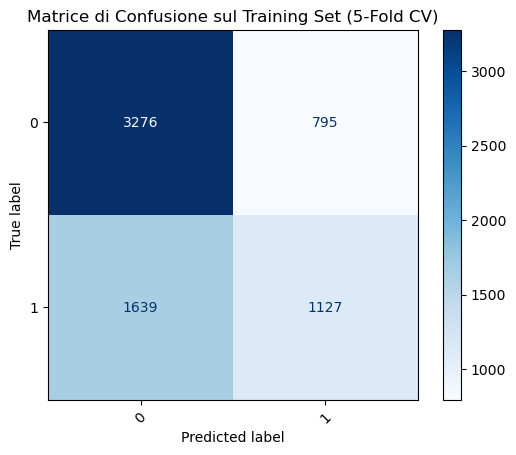


Classification Report (Training Set - 5-Fold CV):
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      4071
           1       0.59      0.41      0.48      2766

    accuracy                           0.64      6837
   macro avg       0.63      0.61      0.60      6837
weighted avg       0.63      0.64      0.63      6837



In [14]:
# Inizializza il modello LinearSVC
svc = LinearSVC(dual=False, random_state=42, max_iter=5000)

# 5-fold cross-validation sul training set (otteniamo predizioni su ogni fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_pred = cross_val_predict(svc, X_train, y_train, cv=cv)

# Matrice di confusione per il training set durante la cross-validation
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)

# Visualizza la matrice di confusione per il training set
disp_train.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("Matrice di Confusione sul Training Set (5-Fold CV)")
plt.show()

# Classification Report per il training set
print("\nClassification Report (Training Set - 5-Fold CV):")
print(classification_report(y_train, y_train_pred))



##### Visualizzazione degli score di Predizione:

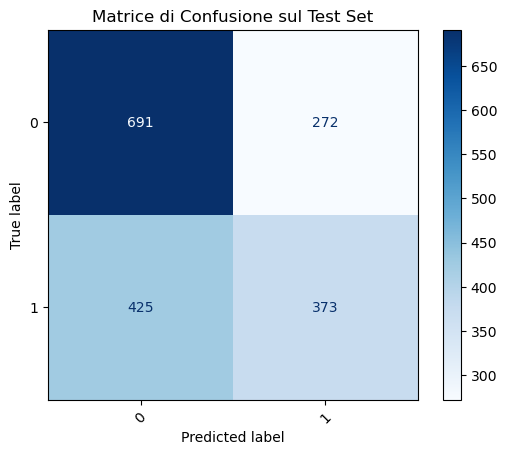


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.62      0.72      0.66       963
           1       0.58      0.47      0.52       798

    accuracy                           0.60      1761
   macro avg       0.60      0.59      0.59      1761
weighted avg       0.60      0.60      0.60      1761



In [15]:
# Addestra il modello sui dati di training
svc.fit(X_train, y_train)

# Predizioni sul test set
test_predictions = svc.predict(X_test)

# Matrice di confusione per il test set
cm_test = confusion_matrix(y_test, test_predictions)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)

# Visualizza la matrice di confusione per il test set
disp_test.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("Matrice di Confusione sul Test Set")
plt.show()

# Classification Report per il test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_predictions))



##### Prediction Scores:

In [12]:
svc = LinearSVC(dual=False, random_state=42, max_iter=5000)
svc.fit(X_train, y_train)
print(svc.classes_)

#Seleziona un campione dal test set
test_sample = X_test.iloc[0].values.reshape(1, -1)

# Predizione della classe
predizione = svc.predict(test_sample)[0]

# Punteggio di decisione
punteggio = svc.decision_function(test_sample)[0]

# Stampa i risultati
print(f'Classe predetta: {predizione}')
print(f'Score for class 0: {-punteggio}')
print(f'Score for class 1: {punteggio}')




[0 1]
Classe predetta: 0
Score for class 0: 0.2816843695104097
Score for class 1: -0.2816843695104097


/home/holymolny/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/home/holymolny/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


##### Feature Importance:

In [5]:
from sklearn.svm import LinearSVC

# Addestra il modello con LinearSVC
svc = LinearSVC(dual=False, random_state=42, max_iter=5000)

# Addestrare il modello con i dati di training
svc.fit(X_train, y_train)

# Estrai i coefficienti per la classe 1 e per la classe 0
coefs_class_1 = svc.coef_[0]  # Coefficienti per la classe 1
coefs_class_0 = -svc.coef_[0]  # Coefficienti per la classe 0 (opposto della classe 1)

# Funzione per visualizzare le feature importance per entrambe le classi
def plot_feature_importance_dual(coefs_class_0, coefs_class_1, features_names, num_to_plot=15):
    # Feature importance per la classe 0
    feature_importances_0 = {feature: abs(coef) for feature, coef in zip(features_names, coefs_class_0)}
    sorted_feature_importances_0 = dict(sorted(feature_importances_0.items(), key=lambda item: item[1], reverse=True))
    
    # Feature importance per la classe 1
    feature_importances_1 = {feature: abs(coef) for feature, coef in zip(features_names, coefs_class_1)}
    sorted_feature_importances_1 = dict(sorted(feature_importances_1.items(), key=lambda item: item[1], reverse=True))
    
    # Plot per la classe 0
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_feature_importances_0.keys())[:num_to_plot], 
             list(sorted_feature_importances_0.values())[:num_to_plot], align='center')
    plt.yticks(rotation=0)
    plt.title("Feature Importance per la Classe 0")
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()  # Inverti l'asse y per vedere le feature più importanti in alto
    plt.show()

    # Plot per la classe 1
    plt.figure(figsize=(10, 6))
    plt.barh(list(sorted_feature_importances_1.keys())[:num_to_plot], 
             list(sorted_feature_importances_1.values())[:num_to_plot], align='center')
    plt.yticks(rotation=0)
    plt.title("Feature Importance per la Classe 1")
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()  # Inverti l'asse y per vedere le feature più importanti in alto
    plt.show()

# Grafico delle feature importance per entrambe le classi
plot_feature_importance_dual(coefs_class_0, coefs_class_1, X_train.columns)


NameError: name 'X_train' is not defined

#### Interpretazione del Grafico:

La feature importance rappresenta l'influenza di ciascuna feature nel determinare il risultato del modello. Maggiore è l'importanza di una feature, maggiore è la sua influenza sulla decisione finale del modello.
<b>Asse Y</b>: Le feature sono ordinate in base alla loro importanza. Le feature in alto hanno un impatto maggiore sulla decisione di classificazione.
<b>Asse X</b>: Il valore del coefficiente di ciascuna feature. I valori possono essere sia positivi che negativi.

Se una feature ha un valore alto e positivo: Significa che questa feature è molto rilevante e contribuisce in modo significativo alla classificazione nella classe 1.

Se una feature ha un valore alto e negativo: Significa che questa feature è rilevante e contribuisce in modo significativo alla classificazione nella classe 0.

Se una feature ha un valore vicino a zero: Indica che quella feature ha un impatto minimo sulla decisione di classificazione.
  
    
